# Recommender Systems

In this lab, we'll be using Keras to build a recommender system. We'll be using the MovieLens dataset, a common benchmark dataset for recommender systems. 

MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using collaborative filtering of members' movie ratings and movie reviews. You can check out the website here: https://movielens.org/

We will download a subset of the dataset containing 100k ratings. There are tens of millions of ratings in the full dataset, spanning hundreds of thousands of users and movies. The subset we'll be using is a good example to demonstrate the concepts in this lab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
from urllib.request import urlretrieve
from pathlib import Path

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path("ml-100k.zip")
ML_100K_FOLDER = Path("ml-100k")

if not ML_100K_FOLDER.exists():
    if not ML_100K_FILENAME.exists():
        urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)
    with ZipFile(ML_100K_FILENAME.name) as zipf:
        zipf.extractall()

The goal of MovieLens is to enable models to predict the rating a user would give to a movie they have not yet watched. This is a classic example of a recommendation system. The dataset is huge, and contains many parts giving information about the movies, the users, and the ratings. To begin with, we will look at the ratings file. Each line in the ratings file (u.data) is formatted as:

`user_id, item_id, rating, timestamp`

Which tells us a single user's rating of a single movie.

We will start by loading the ratings data into a pandas dataframe and then take a look at the first few rows. If you haven't used Pandas before, it's an extremely powerful library for dealing with tabular data. You can think of it as a Python version of Excel.

In [2]:
ML_100K_FOLDER/"u.data"

PosixPath('ml-100k/u.data')

In [3]:
import pandas as pd

raw_ratings = pd.read_csv(ML_100K_FOLDER / "u.data", sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


The second file we'll look at is the movie metadata. This file (u.item) contains information about each movie, including the title and release date. Each line in the file is formatted as:

`movie_id | movie_title | release_date | video_release_date | IMDb_URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western`

As you can see, the genres are binary variables. As with one-hot encoding, a 1 indicates that the movie is of that genre, and a 0 indicates that it is not. We aren't going to work with the genre data in this lab, but it's easy to imagine that it could be useful in a real-world recommendation system.

In [4]:
columns_to_keep = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(ML_100K_FOLDER / "u.item", sep='|', names=columns_to_keep,
                    encoding='latin-1', usecols=range(5))
items

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


By default, the `release_date` column is a string. We can convert it to a `datetime` object using the `pd.to_datetime` function. This will make it easier to work with in the future (if we want to do things like check which date came first, for example).
 
We can also extract the year from the date and store it in a separate column. This will make it easier to do things like plot the number of movies released each year.

In [5]:
items.shape

(1682, 5)

In [6]:
# drop unknown title
items = items[~(items['title']=='unknown')].copy()

In [7]:
items['release_date'] = pd.to_datetime(items['release_date']) # Pandas makes this easy!
items['release_year'] = items['release_date'].dt.year.astype(int) # For later use

In [8]:
items.dtypes

item_id                        int64
title                         object
release_date          datetime64[ns]
video_release_date           float64
imdb_url                      object
release_year                   int64
dtype: object

In [9]:
items['release_year'].value_counts(normalize=True)[:10]

release_year
1996    0.211184
1997    0.170137
1995    0.130280
1994    0.127305
1993    0.074955
1998    0.038667
1992    0.022011
1990    0.014277
1991    0.013087
1989    0.008923
Name: proportion, dtype: float64

For our purposes, it will be easier to work with the data if we merge our two dataframes into a single dataframe. We can do this using the `merge` method. We'll merge the `items` dataframe into the `raw_ratings` dataframe, using the `item_id` column as the key. This will add the movie title and release year to each rating.

In [10]:
raw_ratings.columns

Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object')

In [11]:
# joining on item_id
all_ratings = pd.merge(items, raw_ratings)

In [12]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


### Data preprocessing

It's always important to understand the data you've collected. Thankfully, Pandas continues to make this easy for us. Using the `describe` method, we can get a quick statistical summary of the data.

In [13]:
all_ratings.describe()

,item_id,release_date,video_release_date,release_year,user_id,rating,timestamp
count,99991.000000,99991,0.0,99991.000000,99991.000000,99991.000000,9.999100e+04
mean,425.544399,1988-02-09 00:43:11.369223360,NaN,1987.956216,462.498305,3.529868,8.835296e+08
min,1.000000,1922-01-01 00:00:00,NaN,1922.000000,1.000000,1.000000,8.747247e+08
25%,175.000000,1986-01-01 00:00:00,NaN,1986.000000,254.000000,3.000000,8.794488e+08
50%,322.000000,1994-01-01 00:00:00,NaN,1994.000000,447.000000,4.000000,8.828270e+08
75%,631.000000,1996-09-28 00:00:00,NaN,1996.000000,682.000000,4.000000,8.882600e+08
max,1682.000000,1998-10-23 00:00:00,NaN,1998.000000,943.000000,5.000000,8.932866e+08
std,330.809824,NaN,NaN,14.155523,266.612120,1.125679,5.343572e+06


Let's do a bit more pandas magic to compute the popularity of each movie (number of ratings). We will use the `groupby` method to group the dataframe by the `item_id` column and then use the `size` method to compute the number of ratings for each movie. We will use the `reset_index` method to convert the resulting Series into a dataframe with an `item_id` column.

In [14]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
# join on item_id
items = pd.merge(popularity, items)

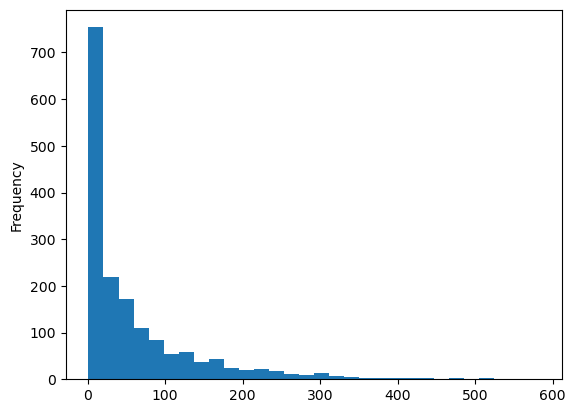

In [15]:
items['popularity'].plot.hist(bins=30);

In [16]:
(items['popularity'] == 1).sum() # Number of movies with only one rating

141

In [17]:
items.nlargest(30, 'popularity')['title'] # Get the 10 most popular movies

49                                 Star Wars (1977)
257                                  Contact (1997)
99                                     Fargo (1996)
180                       Return of the Jedi (1983)
292                                Liar Liar (1997)
284                     English Patient, The (1996)
286                                   Scream (1996)
0                                  Toy Story (1995)
298                            Air Force One (1997)
120                   Independence Day (ID4) (1996)
173                  Raiders of the Lost Ark (1981)
126                           Godfather, The (1972)
55                              Pulp Fiction (1994)
6                             Twelve Monkeys (1995)
97                 Silence of the Lambs, The (1991)
236                            Jerry Maguire (1996)
116                                Rock, The (1996)
171                 Empire Strikes Back, The (1980)
221                 Star Trek: First Contact (1996)
203         

In [18]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,release_date,video_release_date,release_year,user_id,rating,timestamp
count,99991.000000,99991.000000,99991,0.0,99991.000000,99991.000000,99991.000000,9.999100e+04
mean,425.544399,168.086218,1988-02-09 00:43:11.369223360,NaN,1987.956216,462.498305,3.529868,8.835296e+08
min,1.000000,1.000000,1922-01-01 00:00:00,NaN,1922.000000,1.000000,1.000000,8.747247e+08
25%,175.000000,71.000000,1986-01-01 00:00:00,NaN,1986.000000,254.000000,3.000000,8.794488e+08
50%,322.000000,145.000000,1994-01-01 00:00:00,NaN,1994.000000,447.000000,4.000000,8.828270e+08
75%,631.000000,239.000000,1996-09-28 00:00:00,NaN,1996.000000,682.000000,4.000000,8.882600e+08
max,1682.000000,583.000000,1998-10-23 00:00:00,NaN,1998.000000,943.000000,5.000000,8.932866e+08
std,330.809824,121.780688,NaN,NaN,14.155523,266.612120,1.125679,5.343572e+06


In [19]:
indexed_items = items.set_index('item_id')

In [20]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


**Quick Exercise**:

As we have seen, the `groupby` method is a powerful tool to quickly compute statistics on the data. Use it to compute the average rating for each movie.

**Hint**: you can use the `mean` method after the `groupby` method.

In [21]:
avg_ratings = all_ratings.groupby('title')['rating'].mean().rename('avg_rating').apply(lambda x: round(x, 2)).reset_index()
all_ratings = pd.merge(all_ratings, avg_ratings, on='title')

In [22]:
pd.set_option('display.min_rows',25)

In [23]:
# avg ratings of all movies with at least 100 ratings
all_ratings[all_ratings['popularity']>=100].groupby('title')['rating'].mean().rename('avg_rating').reset_index().sort_values(by='avg_rating',ascending=False)

,title,avg_rating
64,"Close Shave, A (1995)",4.491071
263,Schindler's List (1993),4.466443
334,"Wrong Trousers, The (1993)",4.466102
55,Casablanca (1942),4.456790
272,"Shawshank Redemption, The (1994)",4.445230
251,Rear Window (1954),4.387560
322,"Usual Suspects, The (1995)",4.385768
294,Star Wars (1977),4.358491
1,12 Angry Men (1957),4.344000
60,Citizen Kane (1941),4.292929


Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [24]:
# print(ratings_train.shape)

In [25]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: supervised ratings prediction

Now let's begin to do some recommendation! We will build a model that takes a user and a movie as input and outputs a predicted rating. We will be taking advantage of embeddings to represent users and movies. That means that each movie and user will have an abstract representation in a continuous vector space. The model will learn these representations based on the ratings.

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/notebooks/images/rec_archi_1.svg" style="width: 600px;" />

In [26]:
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Dot
from keras.models import Model

In [27]:
# For each sample we input the integer identifiers
# of a single user and a single item
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))
        
        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mae')

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Monitoring runs

When training a model with Keras, we get a `history` object back that contains lots of information about the training run. We can use this to plot the training and validation loss to see how the model has improved during training.

In [28]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - loss: 3.3106 - val_loss: 1.0445
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - loss: 0.9043 - val_loss: 0.7867
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - loss: 0.7548 - val_loss: 0.7576
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - loss: 0.7217 - val_loss: 0.7520
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - loss: 0.7039 - val_loss: 0.7450
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 0.6849 - val_loss: 0.7397
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - loss: 0.6636 - val_loss: 0.7412
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - loss: 0.6410 - val_loss: 0.7365
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - loss: 0.6236 - val_loss: 0.7387
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - loss: 0.5911 - val_loss: 0.7389
CPU times: user 13.4 s, sys: 4.07 s, total: 17.4 s
Wall time: 10.6 s


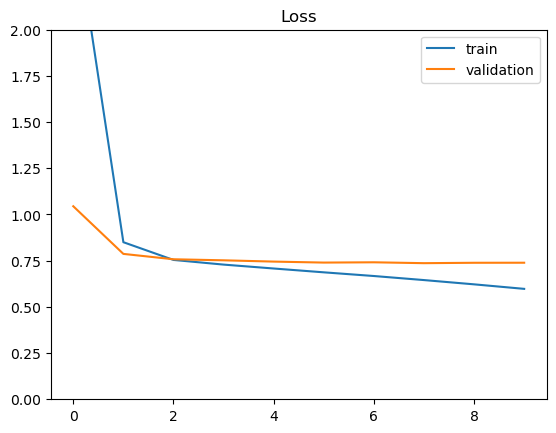

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Does it look like our model has overfit? Why or why not?
- Suggest something we could do to prevent overfitting.


Now that the model is trained, let's check out the quality of predictions:

No, it does not appear that the model has overfit. Validation loss is slightly higher than train loss, but train loss does not improve signifantly from epoch=2 to epoch=10, suggesting waste of effort and potentially unpredictive features.

In [30]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
Final test MSE: 0.922
Final test MAE: 0.740


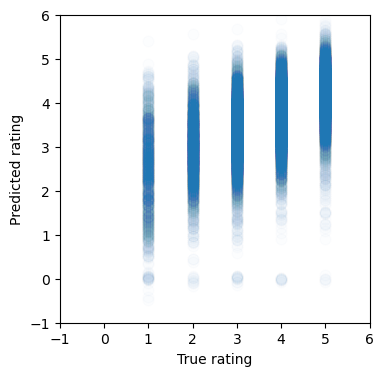

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

This graph shows us the range of predicted ratings our model gives, organized by the true rating. We can see that generally, the higher the true rating the higher the predicted rating, although there is quite a range of predictions for each instance. That's okay - our model is very simple, and human preferences are very complex!

Taking a look at the Mean Absolute Error, hopefully you got something around 0.75. This means that, on average, our predicted ratings are about 0.75 stars off from the true ratings. This is a pretty good result for a first attempt. We could probably do better with a more complex model, but we'll leave that for another time.

### Model Embeddings

Our model was built with two embedding layers. These layers have learned a representation of both the users and the movies in our dataset. We can extract these representations and use them to find similar movies or users. We can also do interesting exploratory analysis, like finding the most popular movies among our users, or finding the users that are most interested in a given movie.

In [32]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [33]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [34]:
item_id = 11
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=11: Seven (Se7en) (1995)


In [35]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=11
[-0.30523863 -0.32749653 -0.32906374  0.2349686  -0.12985575 -0.39554608
  0.23782246  0.14720552  0.40501013 -0.2645736  -0.46876928 -0.49571425
  0.39463922 -0.31600693 -0.23461728  0.32806     0.21445793 -0.12023398
 -0.2904939  -0.40648097  0.3121797   0.0727315   0.09336434 -0.03988437
  0.2965822   0.18902232  0.1451559  -0.29130104  0.19905469  0.36887687
  0.2085474   0.25965673  0.06719134 -0.24238317  0.05835394 -0.18597972
  0.2821172   0.38558486 -0.33680215  0.0229846   0.17243513  0.14033669
 -0.3485023   0.24734889  0.08862611  0.30291992 -0.37480053 -0.31952682
 -0.29937017  0.32082754  0.15234238  0.36523244  0.06491048  0.21930295
 -0.3407661   0.4066532  -0.25411493  0.14424743  0.3294129  -0.32236665
 -0.3637983   0.16584939 -0.22843735  0.21054047]
shape: (64,)


As we discussed in lecture, our embeddings are not directly interpretable - we can't look at, say, a value of 0.297 in the embedding vector and say "this means that the movie is a drama". As an aside, there is a field of research dedicated to making _interpretable_ embeddings, but it's not something we'll cover in this course. 

### Finding our most similar items

Now we can have some fun, investigating the embeddings we've learned. We can start by finding the most similar items to a given item. We can do this by computing the cosine similarity between the item's embedding and the embedding of every other item. We can use the `cosine_similarity` function from `sklearn` to do this.

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine(a, b):
    # Reshape to the shape our function expects
    a = a.reshape(1, -1)
    b = b.reshape(1, -1)
    return cosine_similarity(a, b)[0, 0]

In [37]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")
    
print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.901


It makes sense that the original Star Wars, and its later sequel Return of the Jedi have a high similarity. Let's try some other examples:

In [38]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.674


In [39]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.779


In [40]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


*Quick Exercise*:

- Find some other films and compare their similarity. Do the results make sense to you? Can you find a pair of films that are very _dissimilar_?

In [41]:
# Code to help you search for a movie title
partial_title = "titanic"
indexed_items[indexed_items['title'].str.lower().str.contains(partial_title)]

# print_similarity(127,313, item_embeddings, indexed_items['title'])
# print_similarity(511,405, item_embeddings, indexed_items['title'])
print_similarity(185,405, item_embeddings, indexed_items['title'])

Psycho (1960)
Mission: Impossible (1996)
Cosine similarity: 0.556


Sometimes, even without knowing anything about a user, we can recommend films by asking them about a film that they do like. The code below compares the similarity of a given film to all others, and returns the most similar films.

In [42]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    # Compute the cosine similarity between the item and all other items
    sims = cosine_similarity(item_embeddings[item_id].reshape(1, -1),
                             item_embeddings).ravel()
    
    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs]))

# Find the most similar films to "Star Wars"
most_similar(405, item_embeddings, indexed_items["title"], top_n=10)

[(405, 'Mission: Impossible (1996)', 1.0),
 (742, 'Ransom (1996)', 0.86762273),
 (597, 'Eraser (1996)', 0.85423917),
 (274, 'Sabrina (1995)', 0.84235406),
 (117, 'Rock, The (1996)', 0.84169436),
 (105, 'Sgt. Bilko (1996)', 0.8386044),
 (118, 'Twister (1996)', 0.8359809),
 (763, 'Happy Gilmore (1996)', 0.83499146),
 (1615, 'Warriors of Virtue (1997)', 0.83343655),
 (161, 'Top Gun (1986)', 0.83218026)]

In [43]:
# Find the most similar films to "Star Trek VI: The Undiscovered Country"
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(227, 'Star Trek VI: The Undiscovered Country (1991)', 0.99999994),
 (578, 'Demolition Man (1993)', 0.9036176),
 (560, "Kid in King Arthur's Court, A (1995)", 0.9034378),
 (2, 'GoldenEye (1995)', 0.89595306),
 (210, 'Indiana Jones and the Last Crusade (1989)', 0.89393044),
 (1596, 'Nemesis 2: Nebula (1995)', 0.8899232),
 (228, 'Star Trek: The Wrath of Khan (1982)', 0.88505554),
 (755, 'Jumanji (1995)', 0.88064307),
 (230, 'Star Trek IV: The Voyage Home (1986)', 0.8805196),
 (1615, 'Warriors of Virtue (1997)', 0.87715226)]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

The [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm enables us to visualize high dimensional vectors in a 2D space by preserving local neighborhoods. We can use it to get a 2D visualization of the item embeddings and see if similar items are close in the embedding space.

In [44]:
from sklearn.manifold import TSNE

item_tsne = TSNE(learning_rate="auto", init="pca", perplexity=30).fit_transform(item_embeddings)

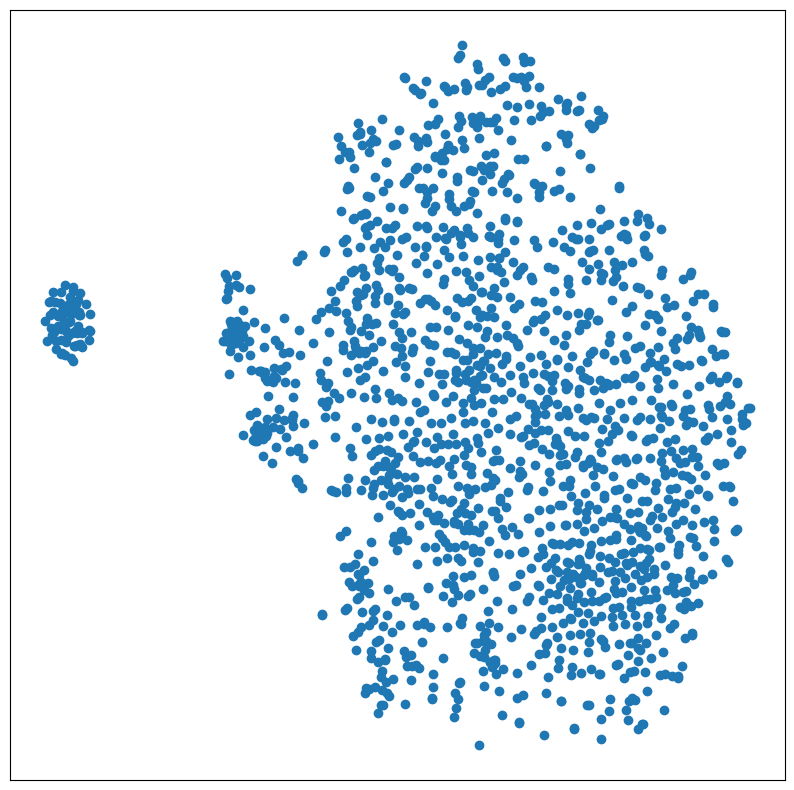

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [46]:
# !pip install plotly
# !pip install nbformat
# !pip list

In [47]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title", "popularity"])

### Exercises

 - Add another layer to the neural network and retrain, compare train/test error.
 - Try adding more dropout and change layer sizes.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user that they haven't seen before. The following code does that.

- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a function that sorts these items and excludes those the user has already seen.

In [48]:
def recommend(user_id, top_n=10):
    item_ids = range(1, items['item_id'].max())
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    user = np.zeros_like(item_ids)
    user[:len(item_ids)] = user_id
    items_ = np.array(item_ids)
    ratings = model.predict([user, items_]).flatten()
    top_items = ratings.argsort()[-top_n:][::-1]
    return [(indexed_items.loc[item_id]["title"], ratings[item_id]) for item_id in top_items]

In [49]:
for title, pred_rating in recommend(10):
    print("    %0.1f: %s" % (pred_rating, title))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
    5.6: Shadow Conspiracy (1997)
    5.5: Nothing to Lose (1994)
    5.3: Selena (1997)
    5.2: Blood For Dracula (Andy Warhol's Dracula) (1974)
    5.2: Tales From the Crypt Presents: Demon Knight (1995)
    5.1: Rocket Man (1997)
    5.1: Surviving the Game (1994)
    5.1: Raiders of the Lost Ark (1981)
    5.1: Little Women (1994)
    5.1: Rainmaker, The (1997)


### Exercises

- Try modifying our neural network to improve recommendation. You could try adding more layers, or using a different loss function. 
- Your goal is to improve the Mean Absolute Error on the test set. Show the results of your best model.

My best model has two additional dense layers, dropout and an embedding size of 8. It achieves a train loss of .68 and a validation loss of .73 which suggests that the problem of overfitting has been addressed while maintaining a low loss.  

The Mean Absolute Error is 0.73.

In [50]:
# Extend and improve the model below
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        self.user_dropout = Dropout(0.4)
        self.item_dropout = Dropout(0.4)

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

        # additional layers
        self.user_transform_layer = Dense(64, activation='relu')
        self.item_transform_layer = Dense(64, activation='relu')

        self.transform_dropout = Dropout(0.5)


    def call(self, inputs):
        user_inputs, item_inputs = inputs

        user_embedded = self.user_embedding(user_inputs)
        user_embedded = self.user_dropout(user_embedded)

        item_embedded = self.item_embedding(item_inputs)
        item_embedded = self.item_dropout(item_embedded)

        user_vecs = self.flatten(self.user_transform_layer(user_embedded))
        user_vecs = self.transform_dropout(user_vecs)
        
        item_vecs = self.flatten(self.item_transform_layer(item_embedded))
        item_vecs = self.transform_dropout(item_vecs)

        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=8, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mae')

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [51]:
# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 1.5608 - val_loss: 0.7561
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - loss: 0.7367 - val_loss: 0.7494
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 0.7253 - val_loss: 0.7442
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - loss: 0.7223 - val_loss: 0.7455
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - loss: 0.7099 - val_loss: 0.7365
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - loss: 0.7063 - val_loss: 0.7362
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 0.6962 - val_loss: 0.7310
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - loss: 0.6881 - val_loss: 0.7294
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - loss: 0.6884 - val_loss: 0.7286
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - loss: 0.6803 - val_loss: 0.7285


In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
Final test MSE: 0.919
Final test MAE: 0.730
